In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# User data
user_df = pd.read_csv('../data/user-df-1-22-2024.csv')
user_df = user_df[user_df.columns[1:]]
user_df

,user,artist_name,play_count,artist_url
0,nyancrimew,Jasmine Thompson,7559,https://www.last.fm/music/Jasmine+Thompson
1,nyancrimew,Eminem,5851,https://www.last.fm/music/Eminem
2,nyancrimew,Watsky,3044,https://www.last.fm/music/Watsky
3,nyancrimew,Linkin Park,2938,https://www.last.fm/music/Linkin+Park
4,nyancrimew,Cavetown,2857,https://www.last.fm/music/Cavetown
...,...,...,...,...
9453845,ankurp,Placebo,377,https://www.last.fm/music/Placebo
9453846,ankurp,blink-182,373,https://www.last.fm/music/blink-182
9453847,ankurp,Sprung Monkey,371,https://www.last.fm/music/Sprung+Monkey
9453848,ankurp,Kings of Leon,366,https://www.last.fm/music/Kings+of+Leon


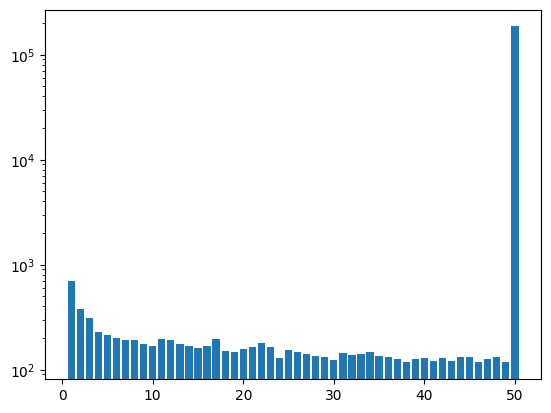

count    194014.000000
mean         48.727669
std           6.731404
min           1.000000
25%          50.000000
50%          50.000000
75%          50.000000
max          50.000000
Name: play_count, dtype: float64

In [3]:
# Plot of how many top artists each user has
num_artists_per_user = user_df.groupby('user').count().groupby('artist_name').count()
x = num_artists_per_user.index
y = num_artists_per_user['play_count']
plt.bar(x, y, log=True)
plt.show()
display(user_df.groupby('user').count()['play_count'].describe())

Takeaway: The vast majority of users have a full 50 top artists, so pruning the users with lower amounts shouldn't affect predictions much. This matters because users with low artist counts will bias our output; if someone's only listened to Drake and Future, predictions based on one of those artists will be heavily skewed towards the other, when in reality the reason they only have Drake and Future logged is poor sample size; it is far more likely that the user barely used last.fm rather than the sum total of their listening habits being relegated only to Drake and Future. However, this raises a question: by pruning users, how many artists do we become unable to recommend because they're out of our database?

To answer this, we will first assign a number to each user corresponding to the amount of top artists they have. Then, from there, we will see which artists are present within just the users with a full 50. Then we will see which artists are present among those with 49 top artists that aren't present within those who have a full 50, then repeating for those with 48 top artists, and so on and so forth.

In [79]:
# How many top artists each user has
user_acs = user_df.groupby('user').count().reset_index()[['user', 'play_count']].rename(columns={'play_count': 'top_artist_count'}).set_index('user')
# user_df but with number of top artists as a column
user_df_with_acs = user_df.join(user_acs, on='user')
# Unique artists within each block of users with a specified number of top artists
artists_by_user_ac = user_df_with_acs.groupby('top_artist_count')['artist_name'].agg(lambda x: set(x))

# Filter artists_by_user_ac so the 49 top artists block doesn't include artists within the 50 top artists block, 
# the 48 top artists block doesn't include any from 49 or 50, etc.
seen_artists = set()
for i in range(50, 0, -1):
    artists_by_user_ac[i] -= seen_artists
    seen_artists = seen_artists.union(artists_by_user_ac[i])

<BarContainer object of 50 artists>

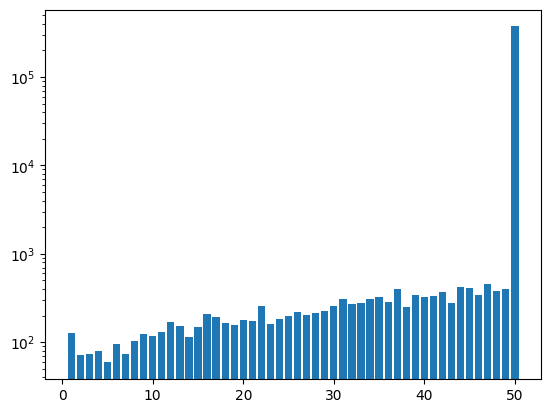

In [80]:
plt.bar(artists_by_user_ac.index, artists_by_user_ac.map(len), log=True)

Now we will plot the number of artists we will lose from our database when we filter out users with below n top artists.

In [83]:
artist_count_lost_per_cutoff = [0]
for i in range(1, 51):
    artist_count_lost_per_cutoff.append(artist_count_lost_per_cutoff[i-1] + len(artists_by_user_ac[i]))

<BarContainer object of 49 artists>

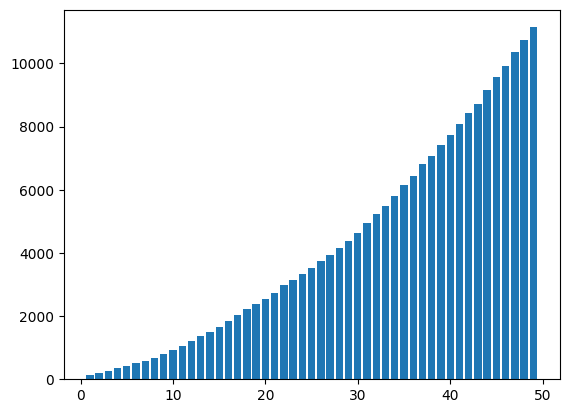

In [88]:
plt.bar(list(range(1, 50)), artist_count_lost_per_cutoff[1:50])

In [26]:
# artists_by_user_ac.map(len)

artist_name
1        696
2        375
3        310
4        230
5        216
6        201
7        192
8        191
9        175
10       167
11       195
12       191
13       176
14       169
15       162
16       168
17       194
18       150
19       148
20       156
21       166
22       178
23       163
24       129
25       154
26       146
27       142
28       134
29       131
30       123
31       145
32       137
33       140
34       147
35       136
36       133
37       127
38       117
39       125
40       130
41       122
42       130
43       122
44       131
45       132
46       119
47       127
48       131
49       119
50    185616
Name: user, dtype: int64